# Weight initialization

## follow the explanation here

https://adventuresinmachinelearning.com/weight-initialization-tutorial-tensorflow/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

%matplotlib inline

In [2]:
mnist = pd.read_csv("data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print "dimension de las imagenes y las clases", X.shape, y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train
X_test  = X_test
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print X_train.shape, y_train_oh.shape

dimension de las imagenes y las clases (1500, 784) (1500,)
(1200, 784) (1200, 10)


# load data and train a simple model

In [16]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K



In [329]:
def get_model(input_dim=784, output_dim=10, layer_sizes=[10]*6, activation="relu", sigma=1):
    
    
    clear_session()
    model = Sequential()
    init1k = keras.initializers.RandomNormal(mean=.0, stddev=sigma, seed=None)
    init1b = keras.initializers.RandomNormal(mean=.0, stddev=sigma, seed=None)

    model.add(Dense(layer_sizes[0], activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0),
                    kernel_initializer=init1k,
                    bias_initializer=init1b
                ))

   
    for i, hsize in enumerate(layer_sizes[1:]):
        model.add(Dense(hsize, activation=activation, name="Layer_%02d_Hidden"%(i+1)))
   
    model.add(Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(len(layer_sizes))))
        
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.reset_states()
    return model

def get_tensors_and_functions(model):
    T_input     = model.input                                        
    T_outputs   = [layer.output for layer in model.layers]         
    T_weights   = model.trainable_weights
    T_gradients = model.optimizer.get_gradients(model.total_loss, T_weights)
    F_outputs   = [K.function([T_input, K.learning_phase()], [out]) for out in T_outputs]    
    F_gradients = [K.function(inputs=[T_input, model.targets[0],  
                                      K.learning_phase()], outputs=[grad]) for grad in T_gradients]

    return T_input, T_outputs, T_weights, T_gradients, F_outputs, F_gradients






In [330]:
model = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=20)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_00_Input (Dense)       (None, 20)                15700     
_________________________________________________________________
Layer_01_Hidden (Dense)      (None, 15)                315       
_________________________________________________________________
Layer_02_Hidden (Dense)      (None, 15)                240       
_________________________________________________________________
Layer_03_Output (Dense)      (None, 10)                160       
Total params: 16,415
Trainable params: 16,415
Non-trainable params: 0
_________________________________________________________________


In [331]:
scale_X=.2
shift_X =.5
!rm -rf log
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/winit', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
model.fit((X_train-shift_X)*scale_X, y_train_oh, epochs=30, batch_size=32, validation_data=((X_test-shift_X)*scale_X, y_test_oh), callbacks=[tb_callback])


Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 0s 390us/step - loss: 2.3325 - acc: 0.0983 - val_loss: 2.3223 - val_acc: 0.1100
Epoch 2/30
1200/1200 [==============================] - 0s 35us/step - loss: 2.3008 - acc: 0.1075 - val_loss: 2.3046 - val_acc: 0.1000
Epoch 3/30
1200/1200 [==============================] - 0s 33us/step - loss: 2.2902 - acc: 0.1208 - val_loss: 2.2967 - val_acc: 0.1133
Epoch 4/30
1200/1200 [==============================] - 0s 33us/step - loss: 2.2839 - acc: 0.1267 - val_loss: 2.2911 - val_acc: 0.1133
Epoch 5/30
1200/1200 [==============================] - 0s 38us/step - loss: 2.2788 - acc: 0.1267 - val_loss: 2.2874 - val_acc: 0.1133
Epoch 6/30
1200/1200 [==============================] - 0s 34us/step - loss: 2.2718 - acc: 0.1317 - val_loss: 2.2801 - val_acc: 0.1133
Epoch 7/30
1200/1200 [==============================] - 0s 37us/step - loss: 2.2645 - acc: 0.1292 - val_loss: 2.2742 - val_acc: 0.1133
Epoch 8

# Effects of different initializations

understand carefully the following function

check the notebook on **Inspecting model internals** to understand `get_tensors_and_functions` and the objects it returns

In [374]:

def train_experiment(model, sigma, X_train, X_test):
    model = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=sigma)
    T_input, T_outputs, T_weights, T_gradients, F_outputs, F_gradients = get_tensors_and_functions(model)

    w0_before = model.get_weights()[0].reshape(-1)
    o0_before = F_outputs[0]([X_train])[0].reshape(-1)
    g0_before = F_gradients[0]([X_train, y_train_oh])[0].reshape(-1)
    
    model.fit(X_train, y_train_oh, epochs=30, batch_size=32, 
              validation_data=(X_test, y_test_oh), verbose=0)

    w0_after = model.get_weights()[0].reshape(-1)
    o0_after = F_outputs[0]([X_train])[0].reshape(-1)
    g0_after = F_gradients[0]([X_train, y_train_oh])[0].reshape(-1)

    acc, val_acc = model.history.history["acc"], model.history.history["val_acc"]

    plt.figure(figsize=(20,3))
    plt.subplot(141)
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="test_acc")
    plt.legend();
    plt.grid()
    plt.title("sigma=%.2f"%(sigma))
    plt.xlabel("epoch")
    plt.subplot(142)
    plt.hist(w0_after, bins=30, density=True, label="after", alpha=.5);
    plt.hist(w0_before, bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 weights")

    plt.subplot(143)
    plt.hist(o0_after, bins=30, density=True, label="after", alpha=.5);
    plt.hist(o0_before, bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 outputs")
    
    plt.subplot(144)

    def get_percentile(k, perc=90):
        p = np.percentile(np.abs(k), [perc])[0]
        return k[(k>-p)&(k<p)]

    plt.hist(get_percentile(g0_after), bins=30, density=True, label="after", alpha=.5);    
    plt.hist(get_percentile(g0_before), bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 gradients")

### initializing with a standard normal ($\mu=0$ and $\sigma=1$)

histograms show weights, outputs and gradients before and after training

in good configurations:
- weights move during training
- gradients are spread around zero before training
- outputs before training are spread

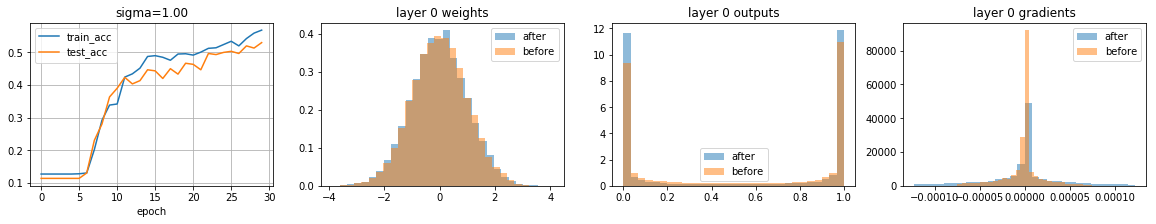

In [375]:
train_experiment(model, sigma=1, X_train=X_train, X_test=X_test)

### initializing with a small $\sigma$


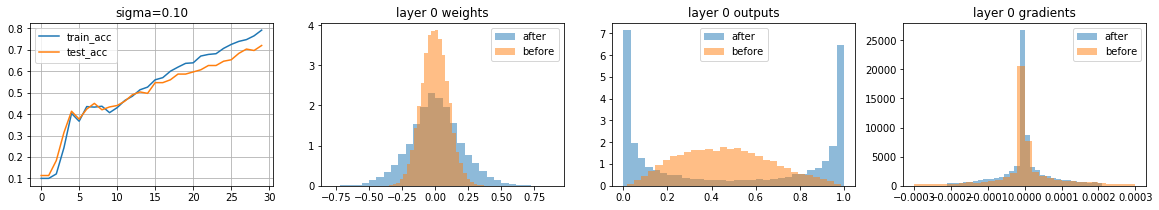

In [368]:
train_experiment(model, sigma=.1, X_train=X_train, X_test=X_test)

### initializing with a large $\sigma$

observe how gradients are very concentrated arounz zero at the beginning of training

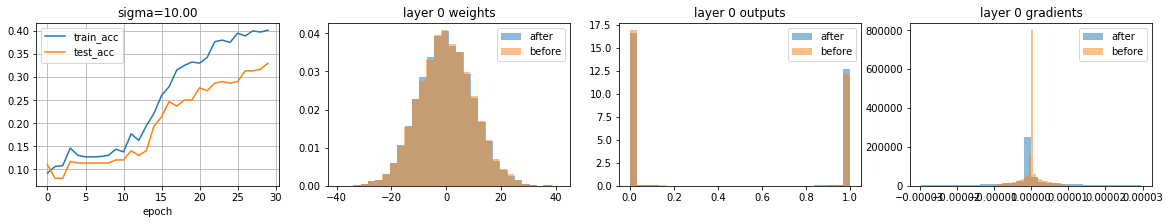

In [376]:
train_experiment(model, sigma=10, X_train=X_train, X_test=X_test)

### initializing with a small $\sigma$ but with large values for input data

Recall that $XW+b$ is what enters the $sigmoid$ function. If large, it will be away from the linear regine around zero. It can be large because of $W$ (large initialization $\sigma$), or because of $X$.


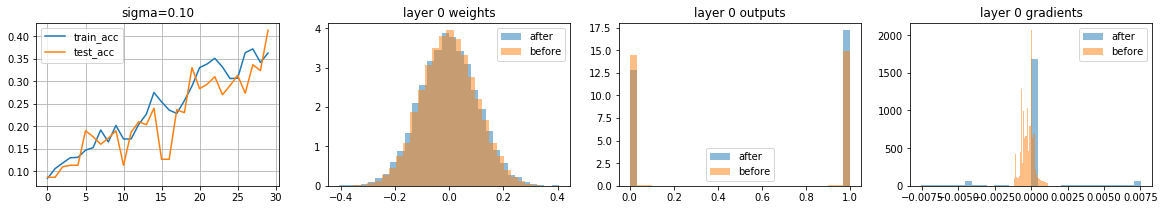

In [370]:
train_experiment(model, sigma=.1, X_train=X_train*100-50, X_test=X_test*100-50)